In [6]:
"""
The complete annotation is in autoencoder_practice.py
"""

# ------ import modules ------
import os
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='cpu')
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from tensorflow.keras.datasets import mnist

In [7]:
# ----- model constuction ------
# - autoencoder (complete model) -
encoding_dim = 32  # compressed size

# Below: input tensor object.
input_img = Input(shape=(784, ))

# Chain 1, encoding layer: from 784 to 32
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Chain 2, encoding layer: from 32 to 784
# NOTE: 0,1 is the output format, simoid
decoded = Dense(784, activation='sigmoid')(encoded)

# - Final model -
autoencoder = Model(input_img, decoded)

# - Seperate encoder model -
encoder = Model(input_img, encoded)

# - Seperate decoder model -
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [8]:
# ------ train the model ------
# - compile/configure the models -
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# - load the MINST data -
(x_train, _), (x_test, _) = mnist.load_data()


# data rescaling to 0-1: min (0)-max(255) normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# data reshape: 60000, 28, 28 -> 60000, 28*28 = 60000, 784
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))


In [9]:
# - fit the model -
# early stop
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [earlystop_callback] # callback is a list

# fitting
"""
input, output = x_train,, x_train: because the input and outpout are the same for autoencoder 
batch_size: we don't set the number of batches. Instead, we set batch_size, which will determine the number of batches
    given the total sample number. 
"""
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256, shuffle=True, validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2752 - val_loss: 0.1881
Epoch 2/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1699 - val_loss: 0.1521
Epoch 3/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1431 - val_loss: 0.1328
Epoch 4/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1280 - val_loss: 0.1214
Epoch 5/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1185 - val_loss: 0.1136
Epoch 6/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1117 - val_loss: 0.1079
Epoch 7/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1067 - val_loss: 0.1034
Epoch 8/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1027 - val_loss: 0.0998
Epoch 9/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0998 - val_

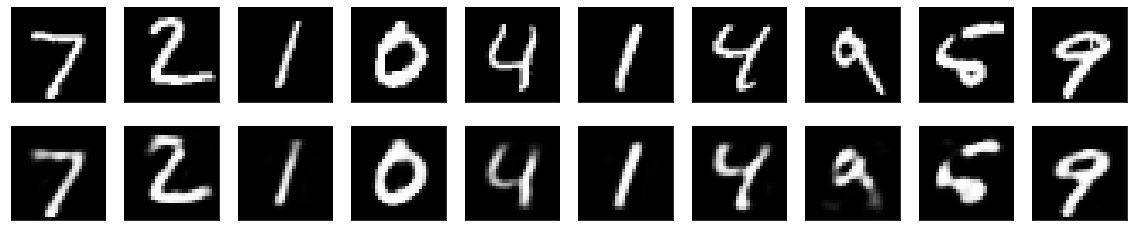

In [11]:
# ------ display resutls ------
# - predict -
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)  # get the encoded image
decoded_imgs = decoder.predict(encoded_imgs)  # decode the encoded image

# - visulization -
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()